# Data mining

## Import library

In [89]:
import pyodbc

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report

## Query data from local database

In [21]:
# Khai báo tên server và tên database
server = 'ADMIN\SQLEXPRESS' # đổi thành server trong máy của mình
database = 'SuperSale_DDS'

cnxn = pyodbc.connect(f'DRIVER=SQL Server;SERVER={server};DATABASE={database}')

### Fact_Sales

In [24]:
# fetch data trong bảng Fact_Sales và lưu trữ nó trong df
cursor = cnxn.cursor()

cursor.execute("SELECT* FROM Fact_Sales")

rows = cursor.fetchall()

columns = [column[0] for column in cursor.description]

# Factsales dataframe
df = pd.DataFrame.from_records(rows, columns=columns)

# Hiển thị 5 dòng dữ liệu mẫu
df.head(5)

,IDDate,IDCustomerType,IDPaymentMethod,IDBranch,IDProduct,IDProductLine,IDGender,QuantityCustomer,Revenue,QuantitySold,Rating
0,7071,9,23,27,2866,39,13,1,457.443,6.0,6.9
1,7072,10,23,28,3553,43,14,1,888.615,10.0,9.0
2,7073,10,21,29,3314,42,14,1,184.086,6.0,5.0
3,7074,9,22,29,2944,39,13,1,132.027,2.0,5.0
4,7075,9,22,27,3122,40,14,1,621.243,9.0,7.7


### Dim_ProductLine

In [36]:
# fetch data trong bảng Fact_Sales và lưu trữ nó trong df
cursor = cnxn.cursor()

cursor.execute("SELECT* FROM Dim_ProductLine")

rows = cursor.fetchall()

columns = [column[0] for column in cursor.description]

# Factsales dataframe
df_product_line = pd.DataFrame.from_records(rows, columns=columns)

# Hiển thị 5 dòng dữ liệu mẫu
df_product_line.head(5)

,IDProuductLine_SK,IDProductLine,ProductLine,Status
0,39,PD001,Health and beauty,Active
1,40,PD002,Electronic accessories,Active
2,41,PD003,Home and lifestyle,Active
3,42,PD004,Sports and travel,Active
4,43,PD005,Food and beverages,Active


## Explore data analysis (EDA)

In [26]:
# Kiểu dữ liệu của df
df.dtypes

IDDate                int64
IDCustomerType        int64
IDPaymentMethod       int64
IDBranch              int64
IDProduct             int64
IDProductLine         int64
IDGender              int64
QuantityCustomer      int64
Revenue             float64
QuantitySold        float64
Rating              float64
dtype: object

Trong DDS, tất cả các biến đã được chuyển sang dạng số

In [29]:
# Tìm missing value trong df
df.isnull().sum()

IDDate              0
IDCustomerType      0
IDPaymentMethod     0
IDBranch            0
IDProduct           0
IDProductLine       0
IDGender            0
QuantityCustomer    0
Revenue             0
QuantitySold        0
Rating              0
dtype: int64

Không có giá trị null trong df

### Distribution of Revenue

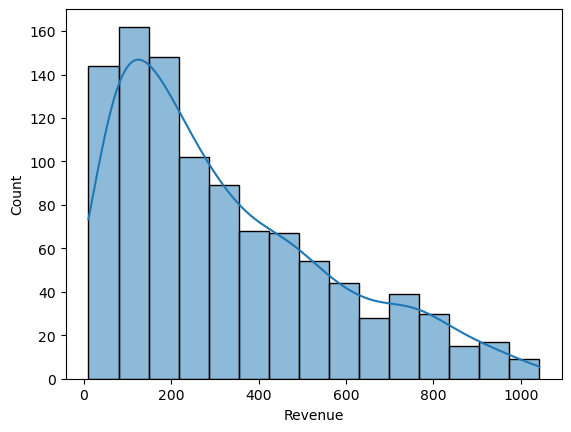

In [32]:
sns.histplot(df['Revenue'], kde=True)
plt.show()

### Distribution of ProductLine

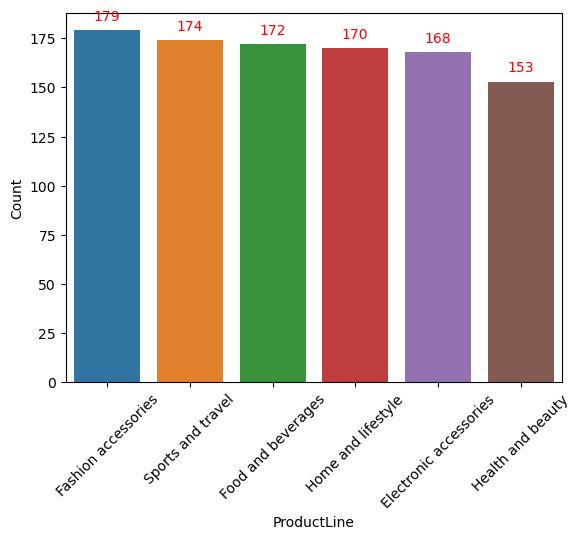

In [48]:
# Merge DataFrame
df_countplot_product_line = df.merge(df_product_line, how='left', left_on='IDProductLine', right_on='IDProuductLine_SK')

# Sắp xếp DataFrame theo giảm dần của ProductLine
sorted_df = df_countplot_product_line['ProductLine'].value_counts().reset_index()
sorted_df.columns = ['ProductLine', 'Count']
sorted_df = sorted_df.sort_values(by='Count', ascending=False)

# Vẽ countplot
ax = sns.barplot(x='ProductLine', y='Count', data=sorted_df)

# Xoay nhãn trục x
plt.xticks(rotation=45)

# Hiển thị giá trị trên từng thanh bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='red')

# Hiển thị biểu đồ
plt.show()

Ta thấy rằng có sự chênh lệch về lượt mua của từng dòng sản phẩm. Thực hiện data mining để dự đoán kết quả mua hàng của khách hàng.

## Data mining: Dự đoán khách hàng có mua dòng sản phẩm Fashion accessories không?

### Bước 1: Xác định yêu cầu
- Phân nhóm khách hàng tương đồng -> Phân tích và dự đoán hành vi của khách hàng trong mỗi nhóm
- Đặc trưng để phân nhóm: dựa vào lịch sử mua hàng của từng dòng sản phẩm:
    - Health and beauty
    - Food and beverages
    - Sports and travel
    - Electronic accessories
    - Home and lifestyle
    - Fashion accessories
- Thông tin trong hoá đơn:
    - CustomerType
    - PaymentMethod
    - Branch
    - Gender
- Thực hiện gom cụm khách hàng --> Clustering
- Dựa vào CustomerType, PaymentMethod, Branch, Gender để dự đoán khách có mua Fashion accessories không?

### Bước 2: Chuẩn bị dữ liệu

In [185]:
# fetch data trong bảng Fact_Sales và lưu trữ nó trong df
cursor = cnxn.cursor()

cursor.execute("""

SELECT
    c.CustomerType,
    pay.PaymentMethod,
    b.Branch,
    p.IDProduct,
    g.Gender,
    case sum(case pl.ProductLine when 'Health and beauty' then 1 else 0 end)
    when 0 then 0 else 1 end as HealthAndBeauty,
    case sum(case pl.ProductLine when 'Food and beverages' then 1 else 0 end)
    when 0 then 0 else 1 end as FoodAndBeverages,
    case sum(case pl.ProductLine when 'Sports and travel' then 1 else 0 end)
    when 0 then 0 else 1 end as SportsAndTravel,
    case sum(case pl.ProductLine when 'Electronic accessories' then 1 else 0 end)
    when 0 then 0 else 1 end as ElectronicAccessories,
    case sum(case pl.ProductLine when 'Home and lifestyle' then 1 else 0 end)
    when 0 then 0 else 1 end as HomeAndLifestyle,
    case sum(case pl.ProductLine when 'Fashion accessories' then 1 else 0 end)
    when 0 then 0 else 1 end as FashionAccessories
FROM Fact_Sales fs LEFT JOIN Dim_Date d on fs.IDDate = d.IDDate
    LEFT JOIN Dim_CustomerType c on fs.IDCustomerType = c.IDCustomerType
    LEFT JOIN Dim_PaymentMethod pay on fs.IDPaymentMethod = pay.IDPaymentMethod_SK
    LEFT JOIN Dim_City b on fs.IDBranch = b.IDBranch
    LEFT JOIN Dim_ProductLine pl on fs.IDProductLine = pl.IDProuductLine_SK
    LEFT JOIN Dim_Gender g on fs.IDGender = g.IDGender
    LEFT JOIN Dim_Product p on fs.IDProduct = p.IDProduct_SK
group by g.Gender, p.IDProduct, b.Branch, pay.PaymentMethod, c.CustomerType
""")

rows = cursor.fetchall()

columns = [column[0] for column in cursor.description]

# Factsales dataframe
df_mining = pd.DataFrame.from_records(rows, columns=columns)

# Hiển thị
df_mining

,CustomerType,PaymentMethod,Branch,IDProduct,Gender,HealthAndBeauty,FoodAndBeverages,SportsAndTravel,ElectronicAccessories,HomeAndLifestyle,FashionAccessories
0,Member,Ewallet,A,PID01,Female,1,0,0,0,0,0
1,Member,Ewallet,A,PID03,Female,0,0,0,0,1,0
2,Member,Credit card,A,PID04,Female,1,0,0,0,0,0
3,Member,Credit card,A,PID05,Female,0,0,1,0,0,0
4,Member,Credit card,A,PID07,Female,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1000,Normal,Cash,C,PID943,Male,0,0,1,0,0,0
1001,Normal,Ewallet,C,PID943,Male,0,0,1,0,0,0
1002,Member,Ewallet,A,PID95,Male,1,0,0,0,0,0
1003,Member,Credit card,A,PID97,Male,0,1,0,0,0,0


### Kiểu dữ liệu của df_mining

In [146]:
df_mining.dtypes

CustomerType             object
PaymentMethod            object
Branch                   object
IDProduct                object
Gender                   object
HealthAndBeauty           int64
FoodAndBeverages          int64
SportsAndTravel           int64
ElectronicAccessories     int64
HomeAndLifestyle          int64
FashionAccessories        int64
dtype: object

Các cột trong df_mining đều thuộc dạng discrete column vì chúng là categorical value

### Bước 3: Chọn mô hình: Dự đoán khách hàng có mua dòng sản phẩm Fashion Accessories không?

In [170]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# 1. Chuẩn bị dữ liệu
# Predict column
target_column = 'FashionAccessories'
# Input column
features = ['CustomerType', 'PaymentMethod', 'Branch', 'IDProduct', 'Gender']

X = df_mining[features].copy()  # Create a copy of the DataFrame
y = df_mining[target_column]

# 2. Chuyển đổi dữ liệu
# Manual encoding for categorical columns
for col in X.columns:
    if X[col].dtype == 'object':
        label_encoder = LabelEncoder()
        X[col] = label_encoder.fit_transform(X[col])

# 3. Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Xây dựng và huấn luyện mô hình Decision Tree
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Trích xuất độ quan trọng của các features
feature_importances = model.feature_importances_

# Tạo DataFrame để hiển thị độ quan trọng của các features
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sắp xếp DataFrame theo độ quan trọng giảm dần
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# In ra độ quan trọng của các features
print("Feature Importances:")
print(feature_importance_df)

# 5. Đánh giá mô hình
y_pred = model.predict(X_test)

# Print predictions
print("\nPredictions:")
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(result_df)

Feature Importances:
         Feature  Importance
3      IDProduct    0.886047
1  PaymentMethod    0.034226
4         Gender    0.027188
0   CustomerType    0.026444
2         Branch    0.026095

Predictions:
     Actual  Predicted
926       1          1
630       0          0
682       0          1
514       0          0
365       0          0
..      ...        ...
208       1          0
778       1          0
334       0          0
210       1          0
350       0          0

[201 rows x 2 columns]


### Bước 4: Đánh giá mô hình

### Create confusion matrix

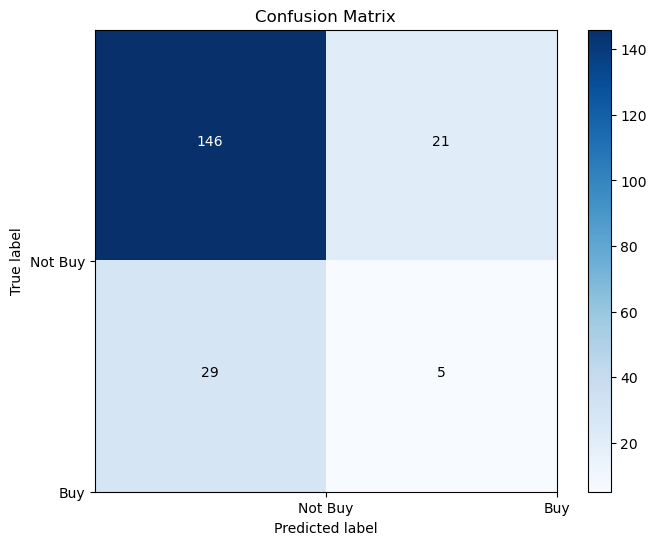

In [169]:
from sklearn.metrics import confusion_matrix

# Tính ma trận confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Vẽ biểu đồ ma trận confusion
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Not Buy', 'Buy']
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.ylabel('True label')
plt.xlabel('Predicted label')

# Hiển thị giá trị trên từng ô của ma trận
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

- Ô ở hàng 1, cột 1 (True Negative - TN = 146): Số lượng trường hợp thực sự thuộc lớp "Not Buy" và mô hình đã dự đoán đúng là "Not Buy".

- Ô ở hàng 1, cột 2 (False Positive - FP = 21): Số lượng trường hợp thực sự thuộc lớp "Not Buy" nhưng mô hình đã dự đoán là "Buy" (dự đoán sai).

- Ô ở hàng 2, cột 1 (False Negative - FN = 29): Số lượng trường hợp thực sự thuộc lớp "Buy" nhưng mô hình đã dự đoán là "Not Buy" (dự đoán sai).

- Ô ở hàng 2, cột 2 (True Positive - TP = 5): Số lượng trường hợp thực sự thuộc lớp "Buy" và mô hình đã dự đoán đúng là "Buy".

### Calculate metrics to evaluate model

In [171]:
TN = 146
FP = 21
FN = 29
TP = 5

# 1. Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# 2. Precision
precision = TP / (TP + FP)

# 3. Recall (Sensitivity)
recall = TP / (TP + FN)

# 4. F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Hiển thị kết quả
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')


Accuracy: 0.7512
Precision: 0.1923
Recall: 0.1471
F1-score: 0.1667


- Model có Accuracy 75% --> có 75% dự đoán đúng.

- Model có Precision 19% --> Trong 26 trường hợp dự đoán là 'Mua', chỉ có 5 trường hợp dự đoán đúng

- Model có Recall 14% --> Trong 34 trường hợp thực sự là 'Mua', chỉ có 5 trường hợp được dự đoán là 'Mua'

- Model có F1-score 16% --> Kết hợp precision và recall

### Characteristics of invoices that purchase Fashion Accessories

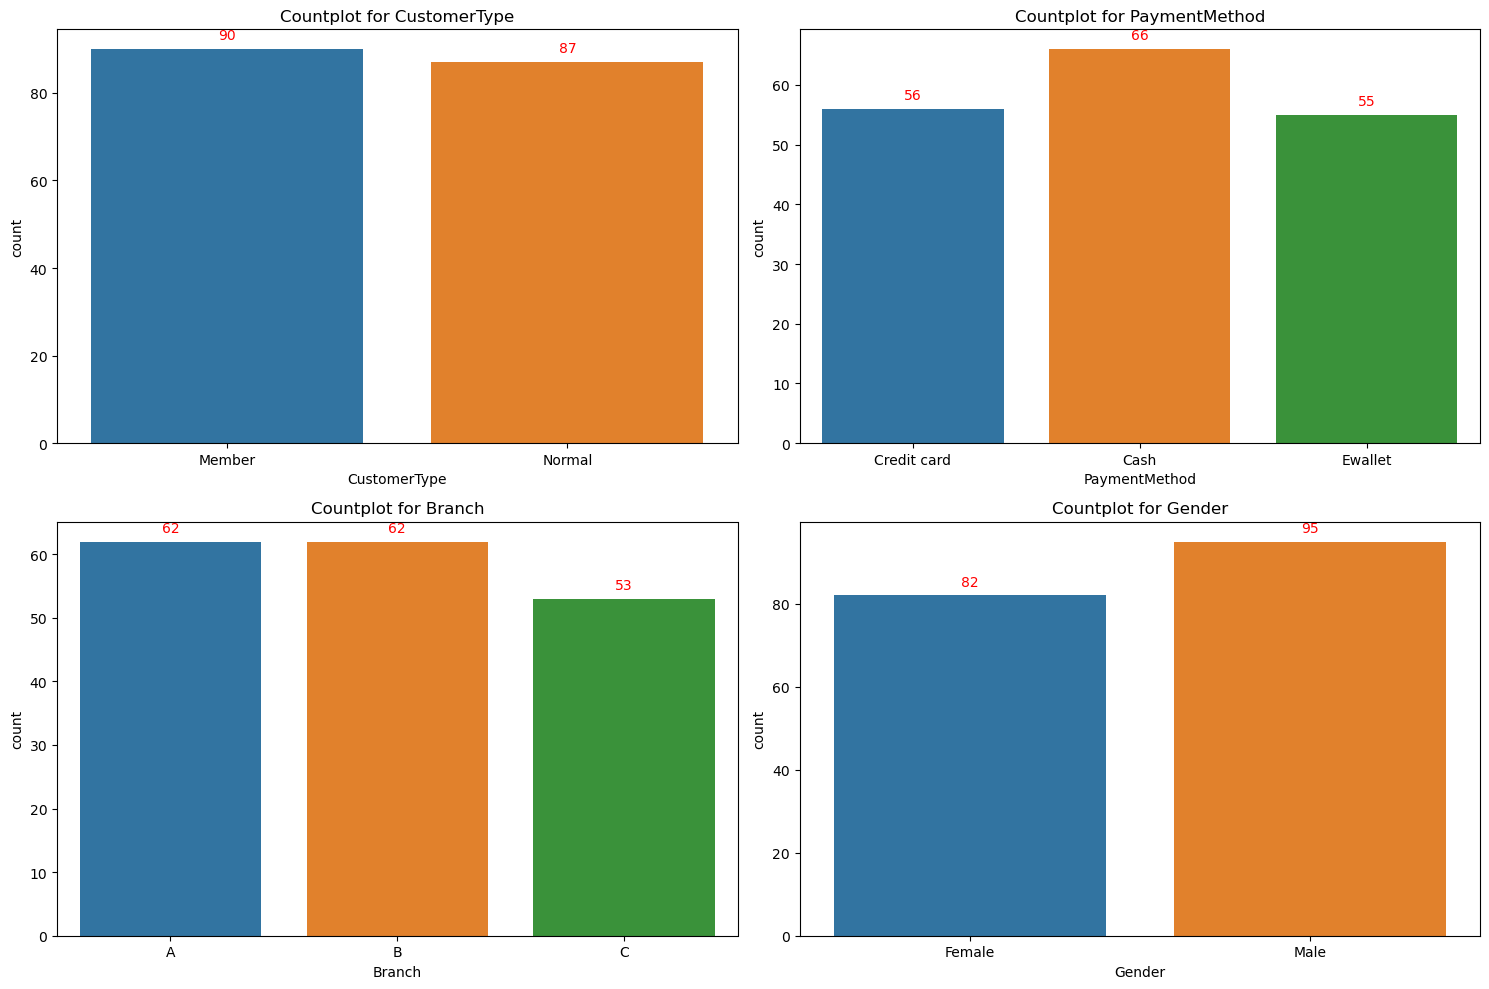

In [228]:
# Select the relevant columns from the DataFrame
df_test = df_mining[df_mining['FashionAccessories'] == 1]
selected_columns = ['CustomerType', 'PaymentMethod', 'Branch', 'IDProduct', 'Gender']
df_test_selected = df_test[selected_columns]

# Plot subplots for each selected column
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Function to annotate each bar with its count
def annotate_bars(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', color = 'red')

# Count plot for CustomerType
sns.countplot(data=df_test_selected, x='CustomerType', ax=axes[0, 0])
axes[0, 0].set_title('Countplot for CustomerType')
annotate_bars(axes[0, 0])

# Count plot for PaymentMethod
sns.countplot(data=df_test_selected, x='PaymentMethod', ax=axes[0, 1])
axes[0, 1].set_title('Countplot for PaymentMethod')
annotate_bars(axes[0, 1])

# Count plot for Branch
sns.countplot(data=df_test_selected, x='Branch', ax=axes[1, 0])
axes[1, 0].set_title('Countplot for Branch')
annotate_bars(axes[1, 0])

# Count plot for Gender
sns.countplot(data=df_test_selected, x='Gender', ax=axes[1, 1])
axes[1, 1].set_title('Countplot for Gender')
annotate_bars(axes[1, 1])

plt.tight_layout()
plt.show()

## Data mining: Dự đoán khách hàng nữ có mua dòng sản phẩm Health and beauty không?

### Bước 2: Chuẩn bị dữ liệu

In [186]:
# Filter Gender = 'Female'
df_mining_female = df_mining[df_mining['Gender'] == 'Female']

df_mining_female

,CustomerType,PaymentMethod,Branch,IDProduct,Gender,HealthAndBeauty,FoodAndBeverages,SportsAndTravel,ElectronicAccessories,HomeAndLifestyle,FashionAccessories
0,Member,Ewallet,A,PID01,Female,1,0,0,0,0,0
1,Member,Ewallet,A,PID03,Female,0,0,0,0,1,0
2,Member,Credit card,A,PID04,Female,1,0,0,0,0,0
3,Member,Credit card,A,PID05,Female,0,0,1,0,0,0
4,Member,Credit card,A,PID07,Female,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
498,Normal,Credit card,C,PID940,Female,0,0,0,0,1,0
499,Normal,Ewallet,C,PID941,Female,0,0,0,0,1,0
500,Normal,Cash,C,PID942,Female,1,0,0,0,0,0
501,Member,Ewallet,A,PID96,Female,0,1,0,0,0,0


### Bước 3: Chọn mô hình: Dự đoán khách hàng nữ có mua dòng sản phẩm Health and beauty không?

In [212]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd

# Chọn các đặc trưng để sử dụng trong dự đoán
features = ['CustomerType', 'PaymentMethod', 'Branch', 'IDProduct', 'Gender']

# Target column
target = 'HealthAndBeauty'

# Lấy dữ liệu cho dự đoán
X = df_mining_female[features].copy()
y = df_mining_female[target].copy()

# Chuyển đổi dữ liệu cho các cột dạng object bằng LabelEncoder
label_encoder = LabelEncoder()
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = label_encoder.fit_transform(X[col])

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Xây dựng và huấn luyện mô hình Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Lấy coefficients của mô hình
coefficients = model.coef_[0]

# Tạo DataFrame để hiển thị độ quan trọng của các features
feature_importance_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Sắp xếp DataFrame theo độ quan trọng giảm dần
feature_importance_df = feature_importance_df.sort_values(by='Coefficient', ascending=False)

# In ra coefficients của các features
print("Coefficients:")
print(feature_importance_df)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Hiển thị actual và predicted values
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print("\nActual vs Predicted:")
print(result_df)

Coefficients:
         Feature  Coefficient
2         Branch     0.042040
0   CustomerType     0.006994
4         Gender     0.000000
3      IDProduct    -0.000506
1  PaymentMethod    -0.154194

Actual vs Predicted:
     Actual  Predicted
268       0          0
73        0          0
289       0          0
155       0          0
104       0          0
..      ...        ...
86        0          0
75        1          0
441       0          0
15        0          0
250       0          0

[101 rows x 2 columns]


### Bước 4: Đánh giá mô hình

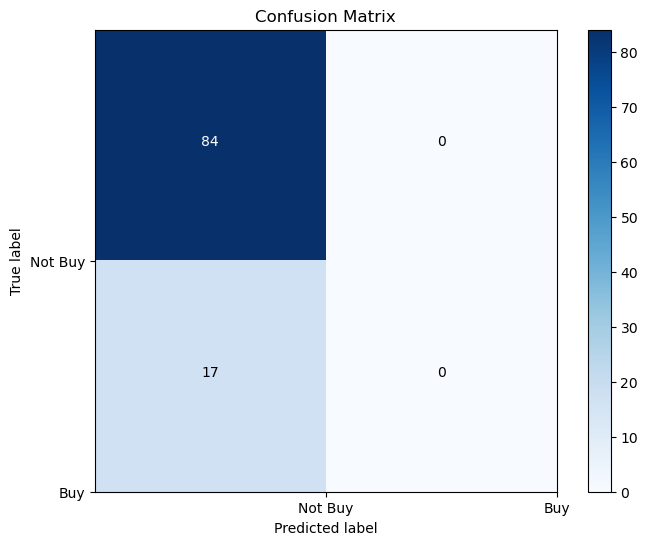

In [211]:
# Tính ma trận confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Vẽ biểu đồ ma trận confusion
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Not Buy', 'Buy']
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.ylabel('True label')
plt.xlabel('Predicted label')

# Hiển thị giá trị trên từng ô của ma trận
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

In [215]:
TN = 84
FP = 0
FN = 17
TP = 0

# 1. Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Hiển thị kết quả
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8317


Model có Accuracy = 83% --> có 83% dự đoán đúng.

### Characteristics of invoices that purchase Health and Beauty by female customers

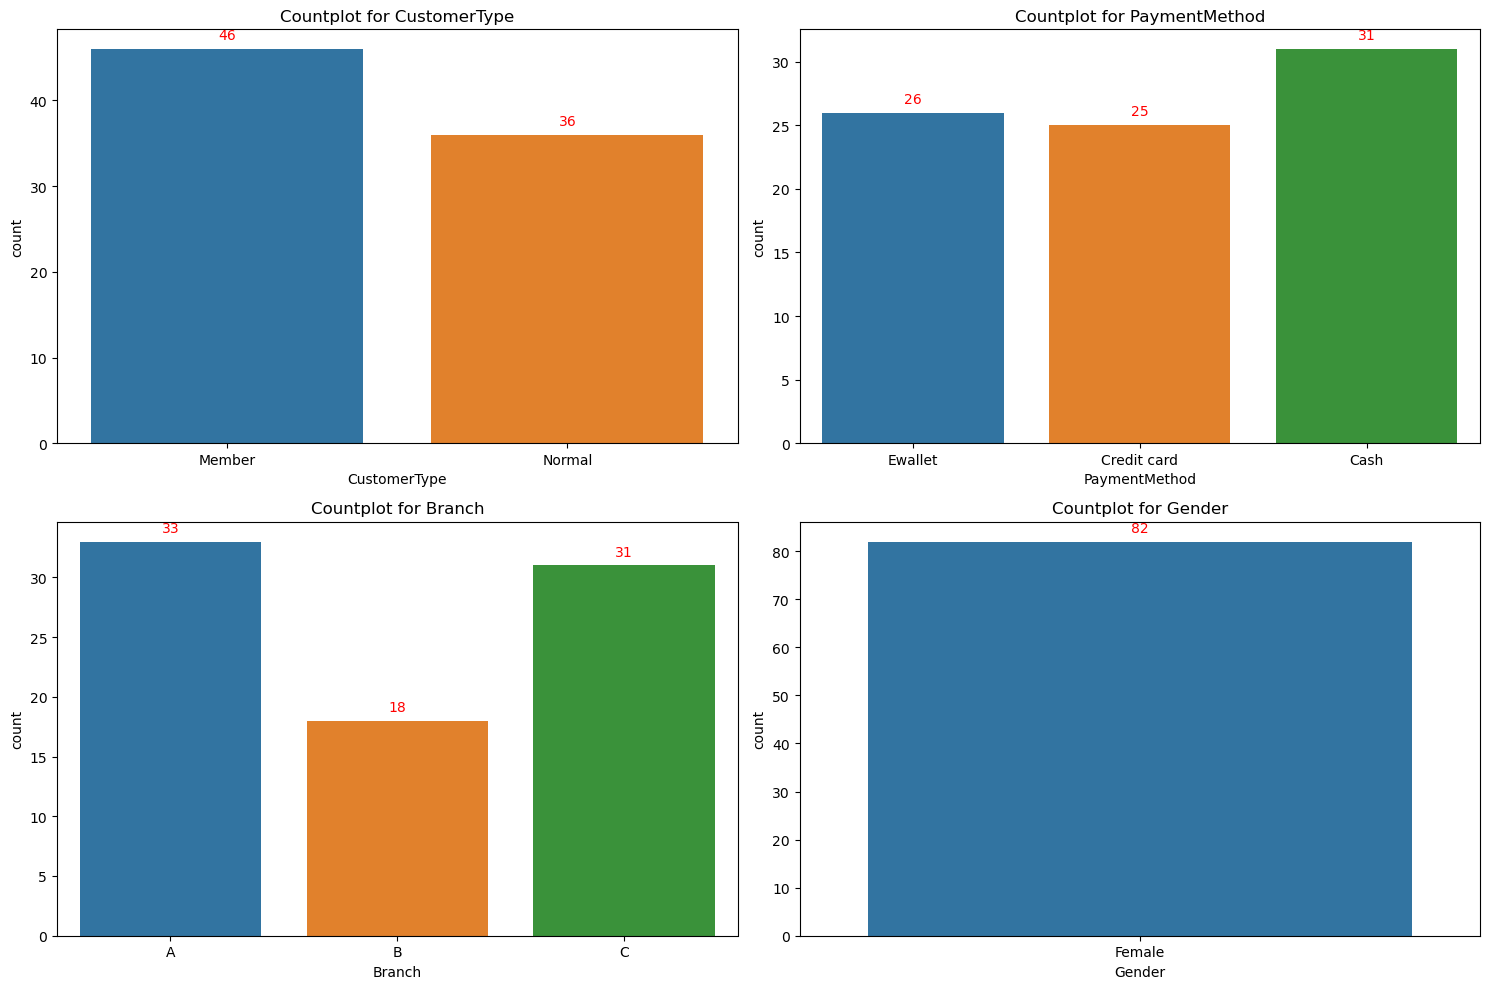

In [229]:
# Select the relevant columns from the DataFrame
df_test = df_mining_female[df_mining_female['HealthAndBeauty'] == 1]
selected_columns = ['CustomerType', 'PaymentMethod', 'Branch', 'IDProduct', 'Gender']
df_test_selected = df_test[selected_columns]

# Plot subplots for each selected column
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Function to annotate each bar with its count
def annotate_bars(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', color = 'red')

# Count plot for CustomerType
sns.countplot(data=df_test_selected, x='CustomerType', ax=axes[0, 0])
axes[0, 0].set_title('Countplot for CustomerType')
annotate_bars(axes[0, 0])

# Count plot for PaymentMethod
sns.countplot(data=df_test_selected, x='PaymentMethod', ax=axes[0, 1])
axes[0, 1].set_title('Countplot for PaymentMethod')
annotate_bars(axes[0, 1])

# Count plot for Branch
sns.countplot(data=df_test_selected, x='Branch', ax=axes[1, 0])
axes[1, 0].set_title('Countplot for Branch')
annotate_bars(axes[1, 0])

# Count plot for Gender
sns.countplot(data=df_test_selected, x='Gender', ax=axes[1, 1])
axes[1, 1].set_title('Countplot for Gender')
annotate_bars(axes[1, 1])

plt.tight_layout()
plt.show()